In [261]:
import numpy as np
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from statsmodels.discrete.discrete_model import Logit, Poisson
from statsmodels.formula.api import glm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score, confusion_matrix,mean_squared_error
import seaborn as sns

scaler = StandardScaler()
# Step 1: Import necessary libraries and load the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils.extmath import softmax
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from kneed import KneeLocator
from sklearn.decomposition import PCA
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

In [262]:
data = pd.read_csv('final_data45.csv')

In [263]:
data['bombing_transport'] = data['att_Bombing/Explosion'] * data['targ_Transportation']
data['success_rulelaw'] = data['v2cldiscw'] * data['suicide']
data['gdppercapita'] = data['GDP']/data['Population']

data['14-15'] = data['Births from mothers aged 15 to 19 years'] * data['Net migration']

data['exp_sui'] = data['suicide'] * data['weap_Explosives']

data['tuamadre'] = data['weap_Explosives'] * data['success']

data['magico'] = data['success'] * (data['n_att']+data['n_targ']+data['n_weap'])

In [264]:
data = data.dropna(subset='nkill')

In [265]:
letal_columns = ['exp_sui','tuamadre','magico','14-15','suicide', 'success_rulelaw', 'multiple', 'v2x_clphy', 'v2x_rule', 'v2cldiscw', 'v2clacfree', 'v2dlencmps', 'v2elembcap', 'v2exhoshog', 'v2clrelig', 'individual', 'v2x_ex_military', 'att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Unarmed Assault', 
                'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party',
                'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_East Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_South Asia', 'reg_Southeast Asia', 
                'reg_Sub-Saharan Africa', 'reg_Western Europe', 'n_weap', 'n_att', 'n_targ', 'gdppercapita', 'Net migration', 'Births from mothers aged 15 to 19 years', 'Population density',  'weap_Chemical', 'weap_Explosives', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Radiological', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)']


In [266]:
kill_columns = [ 'att_Armed Assault', 'att_Assassination', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Chemical', 'weap_Melee', 
                'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Business', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Maritime', 
                'targ_Military', 'targ_NGO', 'targ_Other', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 
                'targ_Tourists', 'targ_Transportation', 'reg_Central Asia', 'reg_East Asia', 'reg_Middle East & North Africa', 
                'reg_South America', 'reg_Southeast Asia', 'reg_Sub-Saharan Africa', 'att3_Hostage Taking (Kidnapping)', 'weap2_Chemical', 'weap2_Sabotage Equipment', 
                'weap3_Sabotage Equipment', 'targ2_Other', 'success', 'suicide', 'n_weap', 'n_att', 'n_targ', 'v2clacfree', 'Net migration', 'Population density', 'gdppercapita', '14-15', 'tuamadre', 'magico']


In [267]:
data = data.dropna(subset=letal_columns + kill_columns )

In [268]:
test_size = 0.3
random_state = 60


In [269]:
final_train,final_test = train_test_split(data,test_size=test_size,random_state=random_state)
print(f'{final_train.shape}')
print(f'{final_test.shape}')

(57406, 162)
(24603, 162)


In [270]:
zeros = final_train[final_train['nkill']>0]
zeros_t = final_test[final_test['nkill']>0]

In [271]:
class_train = final_train[letal_columns+['nkill']].dropna(axis=0, how='any')
class_test = final_test[letal_columns+['nkill']].dropna(axis=0, how='any')
pos_train = zeros[kill_columns+['nkill']].dropna(axis=0, how='any')
pos_test = zeros_t[kill_columns+['nkill']].dropna(axis=0, how='any')

In [272]:
y_regression_train = pos_train['nkill']
y_regression_test = pos_test['nkill']
pos_train.drop(columns='nkill',inplace=True)
pos_test.drop(columns='nkill',inplace=True)

In [273]:
y_classification_train = (class_train['nkill']>0).astype(int)
y_classification_test = (class_test['nkill']>0).astype(int)
class_test.drop(columns='nkill',inplace=True)
class_train.drop(columns='nkill',inplace=True)

In [274]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(pos_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=pos_train.columns, index=pos_train.index)
X_test_scaled = scaler.transform(pos_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=pos_test.columns, index=pos_test.index)

In [275]:
X_poisson_train = sm.add_constant(X_train_scaled)
X_poisson_test = sm.add_constant(X_test_scaled, has_constant='add')


In [276]:
cart_model = DecisionTreeClassifier()
cart_model.fit(class_train, y_classification_train)

DecisionTreeClassifier()

In [277]:
y_class_pred = cart_model.predict(class_test)
accuracy = accuracy_score(y_classification_test, y_class_pred)
print(f'Accuracy of CART model: {accuracy}')

Accuracy of CART model: 0.7995366418729424


In [278]:
po_model = sm.Poisson(y_regression_train, X_poisson_train).fit(disp=0,maxiter=100)
print(po_model.summary())


                          Poisson Regression Results                          
Dep. Variable:                  nkill   No. Observations:                28165
Model:                        Poisson   Df Residuals:                    28121
Method:                           MLE   Df Model:                           43
Date:                Wed, 05 Jun 2024   Pseudo R-squ.:                  0.2005
Time:                        22:20:09   Log-Likelihood:            -1.1985e+05
converged:                       True   LL-Null:                   -1.4990e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                 

Correlation: 0.23
RMSE: 13.77
Bias: -0.43
Coverage: 83.29%


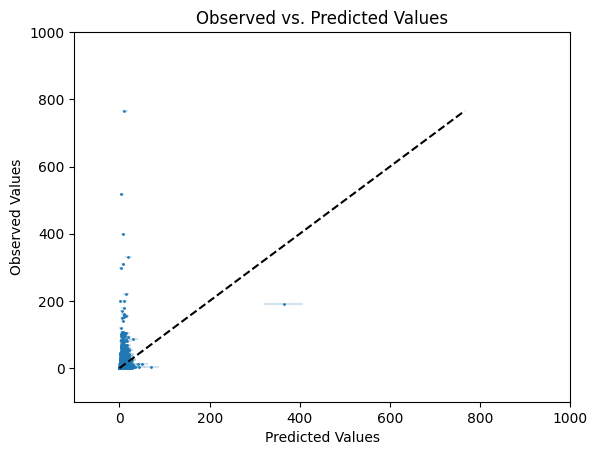

In [279]:
# extract and plot regression coefficients 
beta_mean = po_model.params
beta_cov = po_model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)
#simulated_betas = multivariate_normal.rvs(mean=beta_mean[:-1], cov=beta_cov[:-1,:-1], size=n_simulations)

simulations_df = pd.DataFrame(po_model.params)
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')



# Generate predicted counts using the NB model
predicted_counts = []
for beta_simulation in simulated_betas:
    mean_predicted_rate = np.exp(np.dot(X_poisson_test, beta_simulation))  # log-linear model prediction     must consider without the aplha value
    predicted_counts.append(poisson.rvs(mean_predicted_rate))  # simulate from NB

predicted_counts = np.array(predicted_counts)
monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_regression_test)[0, 1]
rmse = np.sqrt(mean_squared_error(y_regression_test, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_regression_test)  # Mean prediction error
coverage = np.mean((y_regression_test >= prediction_intervals[0,:]) & (y_regression_test <= prediction_intervals[1,:]))

print(f'Correlation: {correlation:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Bias: {bias:.2f}')
print(f'Coverage: {coverage:.2%}')
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_regression_test])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_regression_test, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y_regression_test, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.xlim(-100, 1000)
plt.ylim(-100,1000)
plt.show()

In [280]:
def double_model(data_test,leta_col,kill_col, cart_model, po_model, threshold):
  
    # Predict using the CART model
    lethal_prob = cart_model.predict_proba(data_test[leta_col])[:, 1]  # Get probability of lethal class
    
    # Apply threshold to determine which cases are considered lethal
    lethal_pred = (lethal_prob > threshold).astype(int)
    
    # Scale the data for the Poisson regression model
    x_test_poisson_scaled = scaler.fit_transform(data_test[kill_col])
    X_poisson_test = sm.add_constant(x_test_poisson_scaled)

    # Initialize predictions array with zeros
    predictions = np.zeros(len(X_poisson_test))
    
    # Apply the Poisson regression model only to the predicted lethal cases
    if np.any(lethal_pred):
        poisson_predictions = po_model.predict(X_poisson_test[lethal_pred == 1])
        predictions[lethal_pred == 1] = poisson_predictions
    
    return predictions


In [281]:
# Define your threshold
threshold = 0.8  # This can be adjusted based on your needs

# Use the double model function to make predictions on the test set
predictions = double_model(final_test, letal_columns, kill_columns, cart_model, po_model, threshold)

print(predictions)


[0.         0.         0.         ... 0.         0.         6.77903339]


In [282]:
np.random.seed(42)
n_samples = len(predictions)
simulated_predictions = np.array([predictions + np.random.normal(0, 10, n_samples) for _ in range(1000)])
prediction_intervals = np.percentile(simulated_predictions, [2.5, 97.5], axis=0)

In [283]:
correlation = np.corrcoef(predictions, final_test['nkill'])[0, 1]
rmse = np.sqrt(mean_squared_error(final_test['nkill'], predictions))
bias = np.mean(predictions - final_test['nkill'])  # Mean prediction error

coverage = np.mean((final_test['nkill'] >= prediction_intervals[0,:]) & (final_test['nkill'] <= prediction_intervals[1,:]))

In [284]:
print(f'That is the correlation: {correlation} \n That is the rmse: {rmse}\n This is the bias:{bias}\n This is the coverage: {coverage}')

That is the correlation: 0.27646699324979784 
 That is the rmse: 10.005729891263647
 This is the bias:-0.1202500891064778
 This is the coverage: 0.9854082835426574


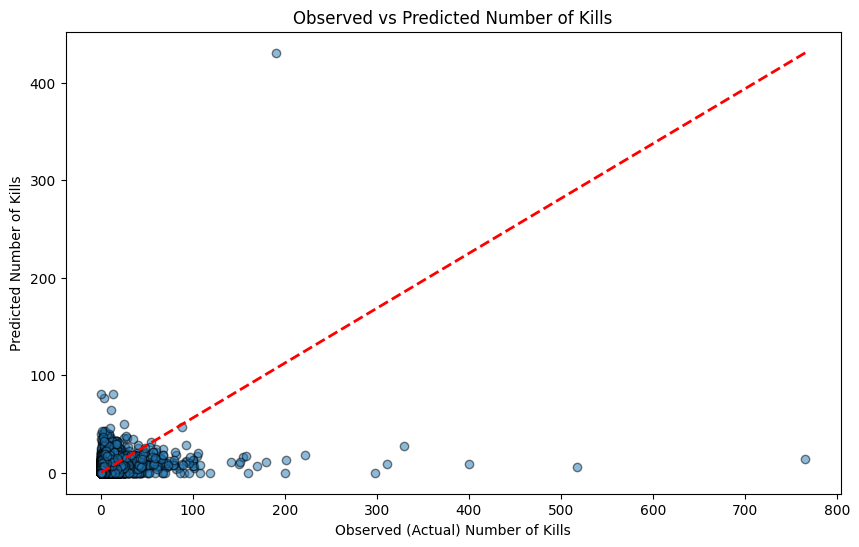

In [285]:
plt.figure(figsize=(10, 6))
plt.scatter(final_test['nkill'], predictions, alpha=0.5, edgecolors='k')
plt.plot([0, max(final_test['nkill'])], [0, max(predictions)], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Observed (Actual) Number of Kills')
plt.ylabel('Predicted Number of Kills')
plt.title('Observed vs Predicted Number of Kills')

# Display the plot
plt.show()

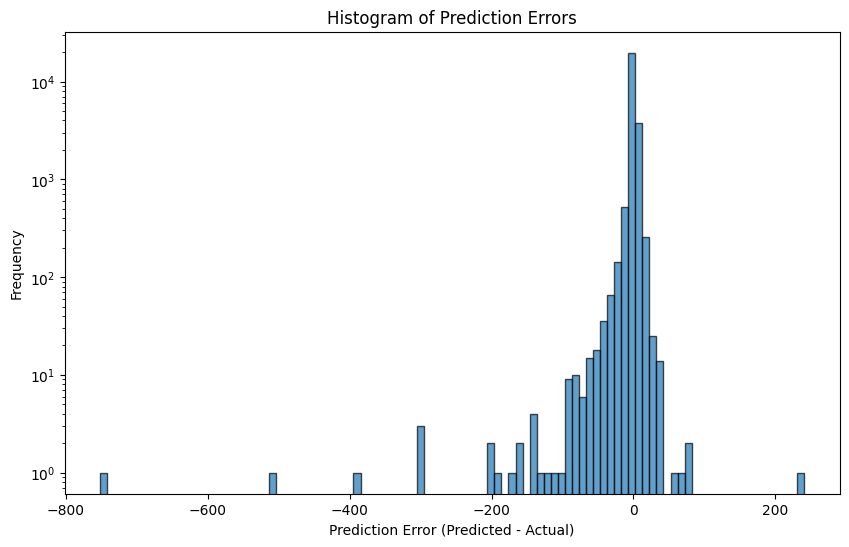

In [286]:
errors = predictions - final_test['nkill']
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=100, edgecolor='k', alpha=0.7)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()
